In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline

In [37]:
df = pd.read_excel('champagne-sales.xlsx')
df.head(3)

,Month,Champagne Sales
0,1-01,2851
1,1-02,2672
2,1-03,2755


In [74]:
df['period'] = df.Month.apply(lambda x: x.split('-')[0])
df['month'] = df.Month.apply(lambda x: x.split('-')[1]).astype(str)
df['year'] = (df.period.astype(int) + 2000).astype(str)
df['date'] = df.year + '-' + df.month
df.date = pd.to_datetime(df.date)
df.set_index(df.date, inplace=True)
df.drop(columns=['Month','period','month','year','date'], inplace=True)
df.head()

,Champagne Sales
date,
2001-01-01,2851
2001-02-01,2672
2001-03-01,2755
2001-04-01,2721
2001-05-01,2946


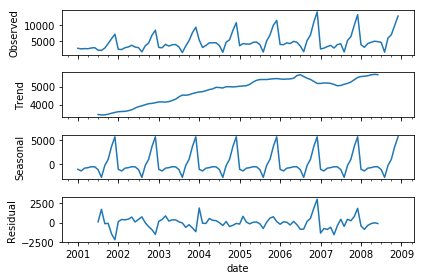

In [77]:
result = sm.tsa.seasonal_decompose(df['Champagne Sales'])
result.plot();
